In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians
import numpy as np

C:\Users\openb\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\openb\anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\openb\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
# import data
links = pd.read_csv("links.csv")
nodes = pd.read_csv("nodes.csv")
loads = pd.read_csv("loads2.csv")

links = links.groupby(['Node1', 'Node2']).sum()

In [3]:
# parameters
loss = 0.05 / 100  # loss per mile (2% per 100mi)
T = 42370  # TIME STEP JAN 1 2010
solar = 1  # amount of solar available

# periods
STEPS = 24

# time steps
TIMES = loads['Time'][:STEPS].values

# nodes to add batteries to

capacity = 200 # capacity in MWh

# method to get distances
def dist(lat1in, lat2in, lon1in, lon2in):
    # approximate radius of earth in miles
    R = 3958.8

    lat1 = radians(lat1in)
    lon1 = radians(lon1in)
    lat2 = radians(lat2in)
    lon2 = radians(lon2in)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [7]:
def cost(batt_nodes):
    # METRICS TO COLLECT
    total_generated = []  # Total generated at each time
    source_generated = []  # Amount generated from each power source by time
    source_limits = []  # Limit from each power source by time
    total_consumed = []  # Total consumed at each time
    power_distance = []  # Power*distance at each time
    objective_value = []  # Total cost: FF Generation + Transmission Loss

    counter = 0

    for T in TIMES:
        # vary solar power
        solar = 1

        # Solar is ON 6am-6pm
        if counter % 24 < 6:
            solar = 0
        elif counter % 24 > 18:
            solar = 0

        # vary wind power
        wind = 1
        # if np.random.uniform() > 0.67:
        #     wind = 0

        # create model
        m = gp.Model("test")
        m.setParam('OutputFlag', 0)

        # create cost function
        cost = gp.LinExpr(0)

        # dictionary of junction (net power) equations at each node
        j = {}

        # create a linear expression at each node
        for i in nodes.index:
            node = nodes['Node'][i]
            j[node] = gp.LinExpr(0)

        # filter to generating nodes
        gens = nodes[nodes['Limit'] > 0]

        # dictionary of generator decision variables
        g = {}

        for i in gens.index:
            # add the decision variable
            node = gens['Node'][i]
            lim = gens['Limit'][i]

            # scale solar
            if gens['Type'][i] == 'Solar':
                lim *= solar

            # scale wind
            if gens['Type'][i] == 'Wind':
                lim *= wind

            g[node] = m.addVar(lb=0, ub=lim)

            # add generation to net power at node
            j[node].add(g[node])

            # add cost to objective
            if gens['Type'][i] == 'Natural Gas':
                cost.add(g[node])

            if gens['Type'][i] == 'Coal':
                cost.add(g[node])

        # FLOWS dictionary indexed by tuple (from, to) pairs
        f = {}

        # distance dictionary indexed by tuple
        d = {}

        # create flow variables
        for i in links.index:
            # index nodes
            n1 = i[0]
            n2 = i[1]

            # create flow (decision) variable in each direction
            f[(n1, n2)] = m.addVar(lb=0, ub=links['Limit'][i])
            f[(n2, n1)] = m.addVar(lb=0, ub=links['Limit'][i])

            # FIND DISTANCE
            lat1 = nodes.loc[nodes['Node'] == n1, 'Latitude'].values[0]
            lat2 = nodes.loc[nodes['Node'] == n2, 'Latitude'].values[0]
            long1 = nodes.loc[nodes['Node'] == n1, 'Longitude'].values[0]
            long2 = nodes.loc[nodes['Node'] == n2, 'Longitude'].values[0]
            distance = dist(lat1, lat2, long1, long2)

            d[(n1, n2)] = distance
            d[(n2, n1)] = distance

            # REMOVED TO NOT DOUBLE COUNT
            # add costs to objective
            # cost.add(f[(n1, n2)], loss * distance)
            # cost.add(f[(n2, n1)], loss * distance)

            # add to junctions (net power balance)
            j[n1].add(f[(n1, n2)], -1)
            j[n1].add(f[(n2, n1)], (1 - loss * distance))
            j[n2].add(f[(n1, n2)], (1 - loss * distance))
            j[n2].add(f[(n2, n1)], -1)

        # LOADS
        t_loads = loads.loc[loads['Time'] == T]
        t_loads = t_loads.drop(columns=['Time', 'Net'])

        # add to junction sets
        for col in t_loads:
            j[int(col)].add(-1 * t_loads[col].values[0])

        # BATTERY
        for batt_node in batt_nodes:

            # Base state is discharging over 16 hours
            j[batt_node].add(gp.LinExpr((capacity / 16)))

            # Charge before 7 and after 22
            if counter % 24 < 7:
                j[batt_node].add(gp.LinExpr(-1 * (capacity / 8)))
            elif counter % 24 > 22:
                j[batt_node].add(gp.LinExpr(-1 * (capacity / 8)))

        # Constraints
        c = {}

        for i in nodes.index:
            node = nodes['Node'][i]
            c[node] = m.addConstr(j[node] == 0)

        # Objective
        obj = m.setObjective(cost, GRB.MINIMIZE)

        # Optimize
        m.optimize()

        # Generation Metrics
        usage = {'Coal': 0, 'Natural Gas': 0, 'Nuclear': 0, 'Hydro': 0, 'Wind': 0, 'Solar': 0}
        limit = {'Coal': 0, 'Natural Gas': 0, 'Nuclear': 0, 'Hydro': 0, 'Wind': 0, 'Solar': 0}

        for i in gens.index:
            node = gens['Node'][i]
            usage[gens['Type'][i]] += g[node].getAttr("x")
            limit[gens['Type'][i]] += g[node].getAttr("UB")

        source_generated.append(usage)
        source_limits.append(limit)

        tot_gen = sum(usage[i] for i in usage)
        total_generated.append(tot_gen)

        # print("\n-----\n")
        # print("Time: %.2f  (%d/%d) " % (T, (counter + 1), STEPS))
        # print("\nGeneration")
        # for i in usage:
        # print("%s: \t %.2f of total (%0.2f of capacity)" % (i, usage[i] / tot_gen, usage[i] / (limit[i] + 1)))

        # Flow Metrics
        # Total Efficiency
        # print("\nTransmission")
        # print("Overall Efficiency: %.4f" % (loads.loc[loads['Time'] == T]['Net'].values[0] / tot_gen))

        total_consumed.append(loads.loc[loads['Time'] == T]['Net'].values[0])

        # Average Distance Traveled
        powdist = sum((f[i].getAttr("x") * d[i]) for i in f)
        # print("Average Distance: %.2f" % (powdist / tot_gen))

        power_distance.append(powdist)

        # print node with highest usage
        # print(int(t_loads.idxmax(axis=1).values[0]))

        counter += 1

    # output plots
    x_axis = range(STEPS)
    #
    # plt.plot(x_axis, total_generated)
    # plt.plot(x_axis, total_consumed)
    # plt.show()
    #
    # plt.close()
    # plt.plot(x_axis, [power_distance[i]/total_generated[i] for i in range(STEPS)])
    # plt.show()
    #
    # plt.close()
    # plt.plot(x_axis, [source_generated[i]['Natural Gas'] for i in range(STEPS)])
    # plt.show()

    # print total FF generation
    lng = sum([source_generated[i]['Natural Gas'] for i in range(STEPS)])
    coal = sum([source_generated[i]['Coal'] for i in range(STEPS)])

    y_axis = [(source_generated[i]['Natural Gas'] + source_generated[i]['Coal']) for i in range(STEPS)]

    plt.plot(x_axis, y_axis, label = str(batt_nodes))

    if len(batt_nodes)>0:
        print("Battery: %.2f MWh" % (lng + coal))
    else:
        print("Base: %.2f MWh" % (lng + coal))
    return lng+coal

Battery: 521523.58 MWh
Battery: 521556.80 MWh
Battery: 522229.29 MWh
Battery: 521513.52 MWh


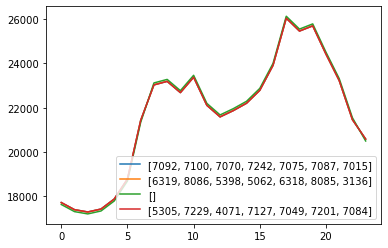

In [8]:
# No batteries
batt_nodes0 = []

# Batteries with highest peak loads
batt_nodes1 = [5305, 7229, 4071, 7127, 7049, 7201, 7084]

# Batteries with highest centralities, ignoring duplicates
batt_nodes2 = [7092, 7100, 7070, 7242, 7075, 7087, 7015]

# Batteries with highest centralities, weighting duplicates at 1000
batt_nodes3 = [6319, 8086, 5398, 5062, 6318, 8085, 3136]

# Batteries with lowest centralities
batt_nodes4 = [[1003, 1015, 1034, 1036, 1064, 2001, 2011]]

for batt in [batt_nodes0, batt_nodes1, batt_nodes2, batt_nodes3, batt_nodes4]:
    try:
        cost(batt)
    except:
        print("Infeasible")

plt.legend()
plt.show()

In [4]:
# drawn from computing centrality notebook
batt_nodes_by_centrality = [7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027, 5086, 7091, 7075, 7368, 7154, 7051, 7015, 7249, 7236, 6094, 7226, 7126, 7151, 6220, 7179, 7011, 6241, 7094, 6160, 7250, 7145, 6240, 6280, 7276, 3048, 5168, 7089, 5274, 6335, 7424, 5248, 7148, 6097, 7016, 7188, 7083, 6043, 7345, 6121, 2069, 5052, 7103, 7254, 6002, 6001, 7214, 5219, 7158, 3007, 7052, 5191, 6099, 5194, 7273, 5143, 7246, 5333, 5157, 6058, 7105, 6036, 6163, 5351, 6316, 7017, 7049, 5027, 5376, 7217, 7178, 7050, 7256, 7174, 7157, 6068, 6338, 5449, 7146, 5173, 6177, 7381, 7086, 1053, 7301, 7173, 5033, 7315, 5323, 6279, 7143, 5117, 7233, 6034, 6300, 7317, 6170, 5049, 6153, 5257, 5145, 6287, 7013, 7213, 6152, 5427, 6061, 6288, 7127, 7054, 7026, 7423, 7132, 5180, 7176, 7067, 1019, 6290, 7039, 5254, 5210, 4033, 7365, 6108, 5034, 6120, 5109, 6040, 7131, 8026, 5105, 8013, 1037, 7295, 5428, 6057, 6178, 2007, 6126, 7425, 6011, 7056, 5060, 7257, 6023, 5221, 7234, 7411, 7084, 5381, 7161, 2126, 6235, 6334, 4132, 1014, 5171, 7223, 7235, 4069, 7044, 7187, 4146, 5091, 6317, 7221, 5245, 6129, 8053, 6204, 5454, 7265, 6037, 6199, 2122, 4147, 7293, 8127, 4014, 6035, 5256, 7020, 7291, 6025, 1033, 8086, 7243, 8148, 6067, 7177, 5104, 8149, 2081, 3001, 5042, 5041, 5040, 5039, 5038, 5037, 5036, 5035, 7106, 5285, 5470, 7306, 6098, 6357, 7206, 5138, 7216, 1047, 2077, 7343, 8128, 6114, 5081, 8106, 3108, 4064, 5163, 6115, 3002, 5061, 6171, 8081, 5227, 5131, 5094, 5202, 5387, 7251, 5371, 7117, 2022, 2018, 6308, 8142, 5026, 5357, 7419, 5439, 5051, 5050, 7292, 4131, 6332, 6309, 4139, 8008, 2102, 4141, 7403, 5063, 5107, 5106, 7072, 5407, 6318, 3015, 5162, 6047, 7260, 1056, 5064, 5212, 5083, 7342, 5047, 5211, 5062, 8126, 5429, 5043, 6175, 1081, 6173, 8065, 6019, 7333, 6291, 6030, 5093, 5165, 6109, 6198, 8025, 5485, 5426, 5284, 7119, 5483, 4188, 7215, 2113, 6352, 7088, 5480, 5448, 6046, 8039, 5270, 8105, 6212, 6286, 8038, 7144, 5443, 5286, 6337, 7275, 5335, 6124, 7401, 2078, 7303, 5322, 3121, 5175, 5188, 5216, 6137, 3069, 5350, 7041, 4029, 8045, 4015, 8084, 5337, 7241, 6285, 1071, 7237, 1024, 7120, 8093, 5004, 5059, 5222, 5447, 6020, 5148, 4066, 6319, 5128, 6123, 5197, 1001, 6343, 1025, 5079, 7040, 6113, 4140, 7028, 7409, 4128, 7316, 6159, 2127, 7057, 5463, 4138, 4137, 4136, 4135, 4134, 4133, 6222, 7319, 7102, 5469, 4007, 5214, 2027, 6184, 4065, 5476, 3049, 5114, 2090, 5113, 7259, 7231, 8021, 5411, 5361, 1052, 1051, 1050, 1049, 1048, 5053, 2072, 6227, 2044, 2064, 8131, 8130, 8129, 7030, 5459, 6142, 7155, 6262, 8022, 5147, 5275, 5389, 8085, 8066, 7069, 5136, 6138, 6328, 6055, 7010, 4006, 5015, 7149, 5132, 2017, 6191, 5090, 7277, 2128, 7180, 6174, 6200, 7282, 2120, 2119, 2118, 2117, 2116, 2115, 2114, 1020, 5409, 7413, 5223, 5332, 6281, 6017, 5280, 1080, 1079, 1078, 1077, 1076, 1075, 1074, 1073, 1072, 6143, 5099, 6134, 5378, 5126, 4112, 5074, 7421, 6065, 6233, 3027, 5054, 5069, 5068, 5067, 5066, 5065, 6344, 7101, 3122, 5084, 2101, 8097, 3011, 1029, 1057, 7219, 1054, 7182, 3023, 6255, 7122, 7121, 1084, 7427, 2065, 5011, 5014, 5048, 5195, 2060, 5326, 5325, 5324, 6239, 7222, 7298, 6336, 6157, 6132, 6226, 6093, 8075, 8005, 8119, 7290, 7394, 7262, 7362, 2003, 6103, 8121, 8157, 5291, 1055, 7313, 5292, 6031, 7336, 2032, 6162, 2040, 5032, 1026, 6141, 5220, 3091, 5070, 5137, 7077, 7078, 8101, 7224, 6060, 3077, 3012, 7199, 2037, 5369, 5368, 5367, 5366, 5365, 5364, 5363, 5362, 7147, 7402, 7230, 3006, 4142, 6026, 5468, 4124, 5098, 5019, 7296, 5111, 5108, 5452, 4028, 8020, 8156, 2105, 2104, 2103, 2002, 2121, 3099, 6314, 7388, 7124, 5213, 4055, 6022, 3132, 2019, 1017, 5016, 5453, 6140, 5460, 1089, 7203, 2015, 2110, 6127, 8019, 5244, 6028, 3042, 6312, 1021, 7019, 7410, 7397, 2111, 3116, 5055, 7090, 3126, 2038, 6180, 5306, 5164, 4197, 4149, 2053, 8099, 8098, 5425, 6223, 4081, 7386, 3059, 8076, 3089, 6161, 4110, 2006, 2005, 2004, 2021, 5414, 7043, 8137, 1018, 3145, 7055, 5022, 7384, 5353, 5085, 4195, 3013, 6232, 5420, 5265, 6169, 6027, 6249, 6248, 6247, 6246, 6245, 6244, 6243, 6242, 8102, 6119, 6256, 5122, 8058, 4086, 6320, 6310, 7003, 7289, 7288, 7287, 7286, 7285, 7284, 7283, 5021, 6327, 2024, 2023, 5334, 5329, 7248, 6118, 3102, 4193, 6221, 6013, 8095, 6149, 6148, 6147, 6146, 6145, 6144, 7198, 6230, 1067, 6102, 4053, 5179, 7297, 8055, 8062, 6188, 3085, 5359, 6211, 7396, 6186, 3016, 8056, 3139, 6324, 4038, 7150, 8143, 6264, 4107, 5203, 5018, 4173, 7264, 4196, 6210, 4030, 6237, 6315, 3047, 1082, 2129, 7347, 5058, 5057, 5056, 6205, 5167, 5166, 7393, 7426, 3054, 8132, 4150, 5316, 3090, 6024, 8094, 6275, 5190, 1061, 3111, 6018, 3118, 3117, 4068, 5347, 5249, 7220, 6325, 6130, 3067, 4074, 3100, 4073, 1010, 4164, 4072, 4048, 8155, 5121, 5450, 6263, 3138, 2012, 6167, 6166, 6165, 6164, 4034, 7059, 1008, 6294, 5479, 5023, 4070, 1041, 5397, 5187, 5013, 7200, 4054, 6292, 6029, 5293, 5261, 5388, 5250, 5205, 6122, 7302, 5408, 4012, 8006, 1005, 1063, 1062, 3113, 3112, 3136, 2068, 4037, 2039, 7415, 3114, 5020, 5071, 2028, 1065, 1043, 1042, 3125, 4099, 4018, 6329, 6190, 8004, 8138, 4169, 7263, 7018, 2106, 1066, 1006, 4035, 6189, 7312, 4013, 7337, 6253, 3129, 3041, 6216, 6215, 6214, 6213, 6021, 5239, 3137, 8059, 8118, 4178, 3017, 7274, 4159, 5156, 3087, 3086, 4051, 5358, 7408, 5119, 6321, 6077, 7001, 1009, 7201, 7420, 2031, 4017, 3035, 3075, 3031, 8104, 2124, 5097, 2030, 5344, 5088, 5456, 4155, 3051, 4184, 7348, 7060, 4071, 7305, 5307, 6297, 6296, 6295, 6293, 5118, 5103, 6322, 5120, 5243, 5240, 8120, 8136, 5273, 5451, 7058, 3082, 5398, 7416, 5161, 5141, 6125, 7367, 7294, 2112, 5279, 5360, 5252, 8064, 5289, 1011, 5241, 5129, 5410, 4077, 4076, 4075, 3038, 5045, 4192, 3068, 4127, 4052, 7129, 5177, 4106, 5217, 3029, 5242, 5226, 4025, 5046, 5413, 5260, 3147, 5025, 5192, 5419, 5418, 5417, 5416, 5415, 5263, 5262, 5385, 5317, 7053, 5283, 5282, 5281, 5473, 5406, 5405, 5404, 5403, 5402, 5204, 5321, 5320, 5319, 5318, 5401, 5198, 7025, 7024, 7023, 7022, 7021, 5196, 5208, 5207, 5206, 2073, 7270, 7269, 7268, 7267, 7266, 2051, 4144, 3045, 3044, 3043, 8144, 5193, 7036, 3134, 2080, 7346, 4057, 7228, 5112, 2093, 2086, 5155, 2133, 5290, 6005, 6014, 6196, 2036, 2098, 8009, 5089, 5271, 8010, 6064, 7042, 2009, 4191, 7066, 7065, 7064, 7063, 7062, 7061, 7432, 4129, 4187, 5310, 5140, 5189, 5372, 8016, 8111, 5146, 6155, 3084, 3083, 5341, 6278, 7218, 7156, 7322, 7046, 7045, 2014, 7366, 7205, 3025, 6350, 5087, 5185, 7406, 5340, 2095, 2094, 5006, 5386, 5305, 2076, 2074, 4168, 2087, 1070, 7034, 7033, 7032, 7031, 4079, 8113, 7029, 2092, 7407, 4100, 3115, 2075, 6012, 1069, 3135, 1060, 1059, 7431, 1022, 6298, 4020, 4089, 4120, 7361, 7360, 7359, 7358, 7357, 7356, 7355, 7354, 7353, 7352, 7351, 7350, 7349, 7229, 2109, 2125, 7253, 1012, 4117, 4108, 1058, 6016, 6044, 4123, 4078, 5422, 5343, 5342, 3078, 6133, 7261, 8096, 7328, 7116, 5235, 4180, 5396, 5075, 6193, 5424, 5423, 7414, 7159, 4170, 7035, 1087, 6351, 1083, 5139, 5296, 1088, 7379, 7378, 7377, 7376, 7375, 7374, 7373, 7372, 7371, 7370, 7369, 3052, 3018, 8114, 5434, 1046, 3146, 8146, 7255, 1023, 6305, 6304, 6303, 6302, 6301, 6299, 5154, 5199, 2055, 8109, 8023, 5336, 4098, 4097, 4096, 4095, 4094, 4093, 4092, 4091, 4090, 3009, 2107, 8073, 8028, 3130, 3046, 8024, 3081, 3079, 3080, 1044, 3024, 1040, 7012, 7170, 7169, 7168, 7167, 7166, 7165, 7164, 7163, 7162, 7160, 8002, 3005, 3020, 3019, 3144, 5234, 5031, 4114, 4186, 3073, 4152, 2067, 4080, 4008, 6015, 2025, 8091, 1004, 1090, 8100, 3141, 7097, 6156, 6187, 6084, 6095, 6107, 7038, 7093, 5142, 7204, 2010, 7391, 3143, 8068, 3140, 5232, 5028, 5229, 5467, 5294, 5475, 5003, 5308, 3065, 6083, 6082, 5133, 4190, 6181, 6010, 6009, 6008, 6007, 6006, 6004, 4183, 5461, 5383, 5382, 3074, 3123, 8027, 4085, 4084, 4083, 4082, 8103, 2062, 2049, 4103, 1085, 3064, 6081, 6090, 6089, 6088, 6087, 6086, 6085, 6003, 6116, 6111, 6110, 5029, 7212, 7211, 7210, 7209, 7208, 7207, 2061, 8069, 5092, 3008, 6260, 6259, 6258, 6257, 5440, 5024, 8152, 7142, 7141, 7140, 7139, 7138, 7137, 7136, 7135, 7134, 7133, 5005, 2089, 5380, 5465, 8134, 8018, 6217, 4003, 3028, 1086, 5392, 7232, 5348, 5186, 6283, 6131, 6274, 6273, 6272, 6271, 6270, 6269, 6268, 6267, 6266, 3036, 6042, 6041, 6039, 6254, 6349, 4019, 7197, 7196, 7195, 7194, 7193, 7192, 7191, 7190, 7189, 7330, 5182, 5170, 7115, 7114, 7113, 7112, 7111, 7110, 7109, 7108, 7107, 8160, 7130, 5144, 8012, 5435, 2071, 2088, 4148, 4056, 4063, 4062, 4061, 4060, 4059, 4058, 5384, 6168, 5464, 8133, 6182, 6201, 8007, 6197, 5115, 7123, 2063, 6096, 6032, 6207, 2097, 6360, 6075, 6080, 6079, 6078, 6076, 3026, 6195, 5395, 6063, 5390, 5391, 2035, 7171, 7172, 7385, 8140, 5355, 5445, 5349, 5116, 5277, 5215, 1030, 4027, 4040, 1013, 4011, 1039, 4050, 4177, 6100, 3063, 3062, 3061, 3060, 6074, 6073, 6072, 6071, 6070, 6069, 3066, 6056, 6265, 6251, 1028, 3110, 6038, 6224, 3021, 7412, 2132, 7186, 7048, 7152, 5264, 5169, 5135, 2042, 5314, 7009, 7008, 7007, 7006, 7005, 7104, 5471, 8159, 8032, 7239, 7238, 2070, 5150, 5312, 2057, 2056, 8147, 5007, 5102, 8017, 8153, 5421, 2046, 1002, 1031, 4047, 4046, 4045, 4185, 4088, 4031, 4039, 4116, 4115, 4126, 1038, 4049, 4022, 4176, 4153, 4166, 4036, 1068, 3093, 4109, 1027, 6128, 6054, 6053, 6052, 6051, 6050, 6049, 6048, 3142, 6066, 3030, 3058, 6092, 3109, 3034, 6091, 3039, 6277, 3004, 3057, 3056, 3055, 3071, 3106, 3105, 6331, 7311, 7310, 7309, 7308, 7307, 7329, 7430, 7326, 7325, 7324, 7323, 7321, 2029, 7383, 7341, 7085, 7271, 2131, 7047, 7183, 6158, 7405, 5127, 7399, 7002, 2041, 8158, 2123, 7082, 7081, 7080, 7079, 8036, 8035, 8034, 8033, 8031, 2059, 7392, 5247, 5176, 5238, 5237, 5432, 5030, 5375, 5184, 2054, 8061, 8060, 8051, 8050, 8049, 8048, 8047, 8046, 8044, 8151, 5125, 5218, 5012, 8040, 5258, 5010, 5304, 8108, 5303, 5302, 5301, 5300, 5299, 5298, 5297, 5225, 8041, 2034, 2050, 1007, 4044, 4043, 4042, 4122, 4113, 4102, 4005, 4021, 4111, 4194, 4175, 4002, 1032, 3120, 4189, 4151, 4130, 4010, 4165, 3010, 1045, 4016, 4156, 4163, 4162, 4161, 4160, 4026, 4145, 4105, 1016, 6112, 4172, 4182, 6276, 1035, 6225, 6045, 6150, 3072, 6340, 6229, 3133, 3033, 3098, 3097, 6176, 6218, 3037, 6252, 3003, 3014, 6185, 3053, 6194, 6139, 1091, 3104, 3070, 7099, 7098, 7096, 3095, 2100, 2099, 6238, 3032, 6219, 6151, 6208, 6355, 6033, 6106, 6105, 6104, 5484, 7304, 6358, 7364, 3092, 7327, 6183, 7429, 7320, 7339, 7380, 7340, 5377, 5231, 7185, 5399, 7125, 2130, 6341, 7244, 7037, 7417, 2079, 5267, 7318, 7227, 7225, 7074, 5134, 5472, 5080, 7344, 7335, 7334, 7332, 5159, 7175, 2013, 7400, 7118, 5446, 5124, 7076, 5209, 7281, 7280, 7279, 2058, 8030, 2008, 8088, 8087, 8083, 7390, 5110, 5276, 5255, 5474, 5236, 5327, 8003, 8071, 8070, 5430, 5481, 8054, 8014, 5346, 2085, 2084, 2083, 5044, 5287, 5373, 5379, 2045, 8043, 5330, 8057, 8090, 5233, 5251, 5313, 8072, 5017, 5230, 5100, 5311, 5482, 5374, 5370, 5183, 5149, 5160, 8015, 5181, 5356, 5178, 5096, 5077, 8063, 5259, 5295, 5400, 8117, 8116, 8115, 8154, 8089, 2043, 8080, 8079, 8078, 8077, 8124, 2033, 5268, 8145, 8150, 8141, 8139, 8135, 8125, 8123, 8122, 8112, 8110, 8107, 8092, 8082, 8074, 8067, 8052, 8042, 8037, 8029, 8011, 8001, 7428, 7422, 7418, 7404, 7398, 7395, 7389, 7387, 7382, 7363, 7338, 7331, 7314, 7299, 7278, 7272, 7258, 7252, 7247, 7245, 7240, 7202, 7184, 7181, 7153, 7128, 7095, 7073, 7071, 7068, 6359, 6356, 6354, 6353, 6346, 6345, 6342, 6339, 6333, 6330, 6326, 6323, 6313, 6311, 6307, 6306, 6289, 6284, 6282, 6261, 6250, 6234, 6231, 6228, 6209, 6206, 6203, 6202, 6192, 6179, 6172, 6154, 6136, 6135, 6117, 6101, 6062, 6059, 5478, 5477, 5466, 5462, 5458, 5457, 5455, 5444, 5442, 5441, 5438, 5437, 5436, 5433, 5431, 5412, 5394, 5393, 5354, 5352, 5345, 5339, 5338, 5331, 5328, 5315, 5309, 5288, 5278, 5272, 5269, 5266, 5253, 5246, 5228, 5224, 5201, 5200, 5174, 5172, 5158, 5153, 5152, 5151, 5130, 5123, 5101, 5095, 5078, 5076, 5073, 5072, 5009, 5008, 4181, 4179, 4174, 4171, 4167, 4158, 4157, 4154, 4143, 4125, 4121, 4119, 4118, 4104, 4101, 4087, 4067, 4041, 4032, 4024, 4023, 4009, 4004, 3131, 3128, 3127, 3124, 3119, 3107, 3103, 3101, 3096, 3094, 3088, 3076, 3050, 3040, 3022, 2108, 2096, 2091, 2082, 2066, 2052, 2048, 2047, 2026, 2020, 2016, 2011, 2001, 1064, 1036, 1034, 1015, 1003]

[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236]
Battery: 521320.36 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082]
Battery: 521219.56 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027]
Battery: 521118.21 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027, 5086]
Battery: 521017.25 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027, 5086, 7091]
Battery: 520916.02 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027, 5086, 7091, 7075]
Battery: 520815.79 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027, 5086, 7091, 7075, 7368]
Battery: 520715.79 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027, 5086, 7091, 7075, 7368, 7154]
Battery: 520614.14 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027, 5086, 7091, 7075, 7368, 7154, 7051]
Battery: 520513.14 MWh
[7070, 7242, 7092, 7014, 7004, 7100, 7087, 7300, 6236, 5082, 7027, 5086, 7091, 707

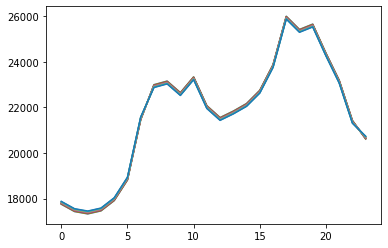

In [17]:
for n in range(10):
    try:
        n_highest_centrality_nodes = batt_nodes_by_centrality[:n]
        
        print(n_highest_centrality_nodes)
        cost(n_highest_centrality_nodes)
    except:
        print('Infeasible')

[1003]
Battery: 522151.57 MWh
[1015, 1003]
Battery: 522066.71 MWh
[1034, 1015, 1003]
Battery: 521988.59 MWh
[1036, 1034, 1015, 1003]
Battery: 521910.78 MWh
[1064, 1036, 1034, 1015, 1003]
Battery: 521825.49 MWh
[2001, 1064, 1036, 1034, 1015, 1003]
Battery: 521724.87 MWh
[2011, 2001, 1064, 1036, 1034, 1015, 1003]
Battery: 521639.46 MWh
[2016, 2011, 2001, 1064, 1036, 1034, 1015, 1003]
Battery: 521537.41 MWh
[2020, 2016, 2011, 2001, 1064, 1036, 1034, 1015, 1003]
Battery: 521441.95 MWh


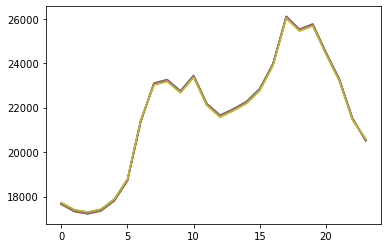

In [13]:
for n in range(1,10):
    try:
        n_lowest_centrality_nodes = batt_nodes_by_centrality[-num:]
        
        print(n_lowest_centrality_nodes)
        cost(n_lowest_centrality_nodes)
    except:
        print('Infeasible')

[5305]
Battery: 522127.65 MWh
[5305, 7229]
Battery: 522026.48 MWh
[5305, 7229, 4071]
Battery: 521916.91 MWh
[5305, 7229, 4071, 7127]
Battery: 521816.62 MWh
[5305, 7229, 4071, 7127, 7049]
Battery: 521715.66 MWh
[5305, 7229, 4071, 7127, 7049, 7201]
Battery: 521614.12 MWh
[5305, 7229, 4071, 7127, 7049, 7201, 7084]
Battery: 521513.52 MWh


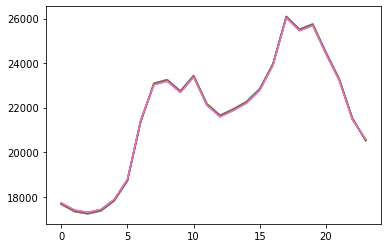

In [16]:
# highest peak loads
batt_nodes1 = [5305, 7229, 4071, 7127, 7049, 7201, 7084]

for num in range(1,8):
    try:
        print(batt_nodes1[:num])
        cost(batt_nodes1[:num])
    except:
        print('Infeasible')

# Monte Carlo random battery locations

In [ ]:
averages = []
num_simulations = 20

for num in range(10, 20):
    averages.append(0)
    for i in range(num_simulations):
        # Generate 7 random battery locations 
        batt = np.random.choice(nodes['Node'], num)
        try:
            averages[-1] += cost(batt)
        except:
            print("Failed")
    averages[-1] /= num_simulations
    print(averages[-1])
    
print(averages)
        
plt.legend()
plt.show()

Battery: 521213.86 MWh
Battery: 521256.86 MWh
Battery: 521287.74 MWh
Battery: 521241.40 MWh
Battery: 521239.12 MWh
Battery: 521320.76 MWh
Battery: 521228.31 MWh
Battery: 521250.07 MWh
Battery: 521288.89 MWh
Battery: 521235.45 MWh
Battery: 521255.73 MWh
Battery: 521252.87 MWh
Battery: 521244.09 MWh
Battery: 521233.92 MWh
Battery: 521250.74 MWh
Battery: 521229.87 MWh
Battery: 521261.03 MWh
Battery: 521234.41 MWh
Battery: 521267.95 MWh
Battery: 521217.00 MWh
521250.5034047298
Battery: 521119.79 MWh
Battery: 521134.57 MWh
Battery: 521126.59 MWh
Battery: 521190.53 MWh
Battery: 521129.74 MWh
Battery: 521144.19 MWh
Battery: 521159.14 MWh
Battery: 521175.84 MWh
Battery: 521154.84 MWh
Battery: 521141.82 MWh
Battery: 521120.21 MWh
Battery: 521150.43 MWh
Battery: 521162.60 MWh
Battery: 521138.12 MWh
Battery: 521186.41 MWh
Battery: 521121.97 MWh
Battery: 521151.37 MWh
Battery: 521139.41 MWh
Battery: 521146.76 MWh
Battery: 521151.40 MWh
521147.2859534739
Battery: 521023.64 MWh
Battery: 521029.65 MW